In [64]:
!nvidia-smi

Mon Oct 21 16:53:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0              29W /  70W |    111MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [65]:
import time

def sum_cpu(vector):
    start_time = time.time()
    result = 0.0
    for element in vector:
        result += element
    end_time = time.time()
    return result, end_time - start_time

In [82]:
from numba import cuda
import numpy as np

@cuda.jit
def sum_kernel(vector, partial_sums):
    # Выделяем shared memory для частичных сумм внутри каждого блока
    shared = cuda.shared.array(128, dtype=np.float64)

    tid = cuda.threadIdx.x
    idx = cuda.grid(1)

    # Каждый поток загружает свой элемент в shared memory, если он в пределах вектора
    if idx < vector.size:
        shared[tid] = vector[idx]
    else:
        shared[tid] = 0.0

    cuda.syncthreads()

    # Редукция в shared memory
    i = cuda.blockDim.x // 2
    while i > 0:
        if tid < i:
            shared[tid] += shared[tid + i]
        cuda.syncthreads()
        i //= 2

    # Результат редукции записываем в массив частичных сумм
    if tid == 0:
        partial_sums[cuda.blockIdx.x] = shared[0]

def sum_gpu(vector):
    start_time = time.time()

    d_vector = cuda.to_device(vector)

    blocks_per_grid = (vector.size + 127) // 128
    d_partial_sums = cuda.device_array((blocks_per_grid,), dtype=np.float64)

    threads_per_block = 128
    sum_kernel[blocks_per_grid, threads_per_block](d_vector, d_partial_sums)

    # Копируем частичные суммы обратно на CPU и суммируем их
    partial_sums = d_partial_sums.copy_to_host()
    result = np.sum(partial_sums)

    end_time = time.time()
    return result, end_time - start_time


In [85]:
import matplotlib.pyplot as plt
import pandas as pd
from numba import NumbaPerformanceWarning
import warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

def run_experiments():
    sizes = [1000, 10000, 100000, 500000, 1000000]
    results = []
    num_trials = 5  # Количество повторений для каждого размера вектора

    for size in sizes:
        cpu_times = []
        gpu_times = []
        cpu_sums = []
        gpu_sums = []

        for _ in range(num_trials):
            vector = np.random.rand(size).astype(np.float64)

            cpu_sum, cpu_time = sum_cpu(vector)
            gpu_sum, gpu_time = sum_gpu(vector)

            cpu_times.append(cpu_time)
            gpu_times.append(gpu_time)
            cpu_sums.append(cpu_sum)
            gpu_sums.append(gpu_sum)

        results.append({
            'Vector size': size,
            'CPU sum': np.mean(cpu_sums),
            'CPU time': np.mean(cpu_times),
            'GPU sum': np.mean(gpu_sums),
            'GPU time': np.mean(gpu_times),
            'Speedup': np.mean(cpu_times) / np.mean(gpu_times)
        })

    return results

results = run_experiments()
print(pd.DataFrame(results).to_markdown(index=False))


|   Vector size |    CPU sum |    CPU time |    GPU sum |    GPU time |   Speedup |
|--------------:|-----------:|------------:|-----------:|------------:|----------:|
|      1000     |    499.489 | 0.000152445 |    499.489 | 0.000961399 |  0.158566 |
|     10000     |   4980.63  | 0.000949097 |   4980.63  | 0.000589752 |  1.60931  |
|    100000     |  50004     | 0.00957384  |  50004     | 0.000820351 | 11.6704   |
|    500000     | 250096     | 0.0499047   | 250096     | 0.00207086  | 24.0986   |
|         1e+06 | 499844     | 0.0988453   | 499844     | 0.00310888  | 31.7945   |


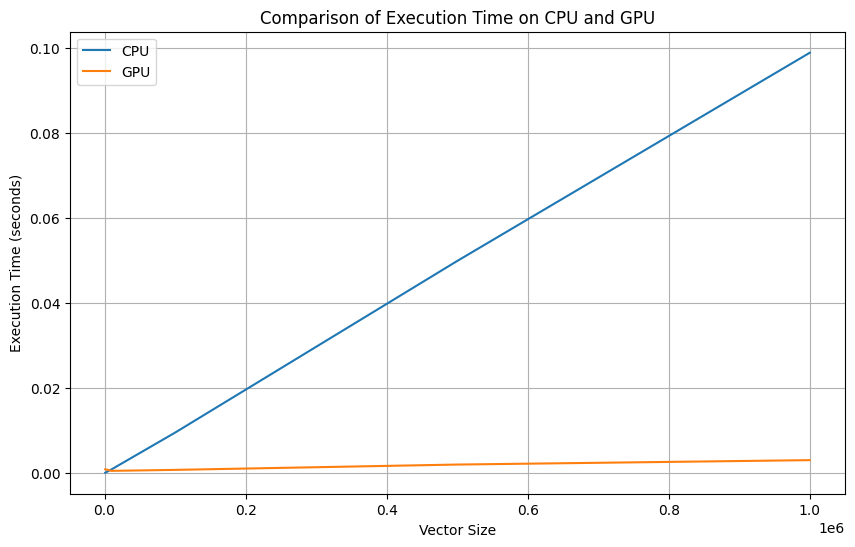

In [86]:
import matplotlib.pyplot as plt

def plot_results(results):
    sizes = [result['Vector size'] for result in results]
    times_cpu = [result['CPU time'] for result in results]
    times_gpu = [result['GPU time'] for result in results]

    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, times_cpu, label='CPU')
    plt.plot(sizes, times_gpu, label='GPU')
    plt.xlabel('Vector Size')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Comparison of Execution Time on CPU and GPU')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results(results)